In [1]:
import cv2
from cv2 import threshold
import numpy as np
import sys
import os
import json
from torchvision import models
from tqdm import tqdm
from pytorch3d.renderer import look_at_view_transform
from math import ceil
import torch
from pytorch3d.io import load_obj, load_ply
from scipy.spatial.transform import Rotation as scipy_rot
from matplotlib import pyplot as plt
from probabilistic_formulation.tests.test_factors_lines import create_k3d_plot
import copy
import ipyplot

%load_ext autoreload
%autoreload 2

from leveraging_geometry_for_shape_estimation.keypoint_matching.get_matches_3d import load_information_depth_camera,create_pixel_bearing,pb_and_depth_to_wc
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.pose import init_Rs,init_Ts,get_pb_real_grid,get_R_limits,get_T_limits, create_pose_info_dict, check_gt_pose_in_limits, get_nearest_pose_to_gt
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.ground_plane import get_model_to_infos,sample_Ts_ground_plane,filter_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_v5 import *
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.visualise_T_factors import plot_lines_T_correct_visualisation, get_pointsize_from_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_visualise_v1 import visualise_single_example
from leveraging_geometry_for_shape_estimation.segmentation.meshrcnn_vis_tools import draw_boxes
from leveraging_geometry_for_shape_estimation.utilities.write_on_images import draw_lines
from leveraging_geometry_for_shape_estimation.data_conversion.create_dirs import dict_replace_value

from probabilistic_formulation.utilities import create_all_possible_combinations,get_uvuv_p_from_superpoint,create_all_possible_combinations_uvuv_p_together
from probabilistic_formulation.factors.factors_T.factors_lines_multiple_T import get_factor_reproject_lines_multiple_T, get_factor_reproject_lines_multiple_T_threshold, get_factor_reproject_lines_multiple_T_with_Scale
from probabilistic_formulation.factors.factors_T.bbox import get_factor_bbox_multiple_T
from probabilistic_formulation.tests.test_reproject_lines import load_lines_2D,load_lines_3D,get_cuboid_line_dirs_3D,plot_lines_T,plot_bbox, plot_points_T

In [31]:
# exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_208_debug_bbox'
exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_206_filtered_lines'
global_info = exp_path + '/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)

# print(global_config["pose_and_shape_probabilistic"]["reproject_lines"]["area_threshold_percentage_side_length"])
# what factors
# global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] = 'False'
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["multiplier_lines"] = 0.02
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "lines"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "bbox"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["enforce_same_length"] = True

global_config["pose_and_shape_probabilistic"]["reproject_lines"]["area_threshold_percentage_side_length"] = 0.06
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["only_allow_single_mapping_to_3d"] = "True"

# info for grid sampling
# global_config["pose_and_shape_probabilistic"]["pose"] = {
#                     "gt_z": "True",
#                     "tilt":{"range": 20,"steps": 20},
#                     "elev":{"range": 45,"steps": 45},
#                     "azim":{"range": 45,"steps": 45},
                    # "x":{"range": 0.3,"steps": 40},
                    # "y":{"range": 0.3,"steps": 40},
                    # "x":{"range": 1.0,"steps": 40},
                    # "y":{"range": 1.0,"steps": 40},
                    # "z":{"range": 5,"steps": 15}
                # }

In [32]:

global_config = dict_replace_value(global_config,'/scratch/fml35/','/scratches/octopus/fml35/')
global_config = dict_replace_value(global_config,'/scratch2/fml35/','/scratches/octopus_2/fml35/')

target_folder = global_config["general"]["target_folder"]
model_to_infos = get_model_to_infos()

# scene0011_01-000400_00_000_03_chair
# name = 'scene0011_01-000400_00_000_03.json'
# name = 'scene0011_00-001200_01_000_02.json'
# name = 'scene0025_00-001400_00_000_01.json'
# name = 'scene0430_00-000400_01_000_00.json'
# name = 'scene0598_01-000400_00_000_00.json'
# name = 'scene0011_00-001900_03_000_00.json'
# name = 'scene0011_01-000200_00_000_00.json' # bug with mapping ?? no all correct
# name = 'scene0011_00-000000_00_000_00.json'
# name = 'scene0011_00-001200_01_000_00.json'
name = 'scene0011_00-002100_03_000_00.json'






In [59]:
cfg_1 = copy.deepcopy(global_config)
cfg_2 = copy.deepcopy(global_config)
cfg_1["pose_and_shape_probabilistic"]["reproject_lines"]["min_line_overlap_percentage_side_length"] = -0.1
cfg_2["pose_and_shape_probabilistic"]["reproject_lines"]["min_line_overlap_percentage_side_length"] = 0.01


In [60]:
configs = [cfg_1,cfg_2]
# line_indices_2ds = [None,[1,4,24]]
line_indices_2ds = [None,None]
line_indices_3ds = [None,None]
use_gt_retrievals = [False,False]
use_gt_Rs = [False,False]
# specific_Ts = [[[ 0.1045, -0.0162,  1.4871]],None]
specific_Ts = [None,None]
# names = ['scene0046_02-000500_00_000_02.json','scene0030_00-001300_00_000_00.json']
# names = ['scene0300_00-000500_00_000_00.json']
names = ['scene0011_00-000100_03_000_03.json','scene0011_00-000100_03_000_03.json']

In [64]:
outputs=[]

# pose_information,imgs,Ts,factors,area_accepted_all_Ts
for i in range(len(configs)):
    pose_information,_,factor_output = get_pose_single_example(configs[i],names[i],model_to_infos,line_indices_2d=line_indices_2ds[i],line_indices_3d=line_indices_3ds[i],use_gt_retrieval=use_gt_retrievals[i],use_gt_R=use_gt_Rs[i],specific_Ts=specific_Ts[i])
    eval_results = eval_factors(factor_output,np.array(pose_information["gt_T"]))
    print(eval_results)
    imgs,img_annotations = visualise_single_example(global_config,names[i],factor_output)
    output = (pose_information,factor_output,imgs,img_annotations,eval_results)
    outputs.append(output)

# print(pose_information)

-0.1
min line overlap -129.6
min line overlap -129.6
{'top_1': 0, 'top_5': 0, 'top_10': 0, 'top_30': 1, 'top_100': 9, 'first_correct': 11}
0.01
min line overlap 12.96
min line overlap 12.96
{'top_1': 0, 'top_5': 1, 'top_10': 1, 'top_30': 2, 'top_100': 13, 'first_correct': 5}



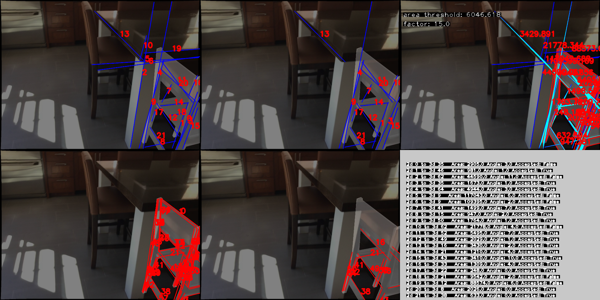
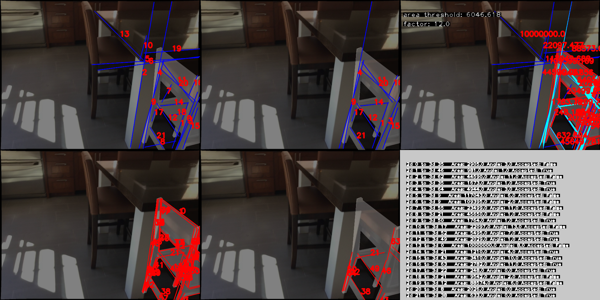


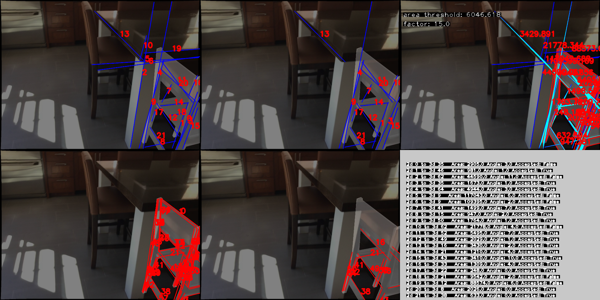
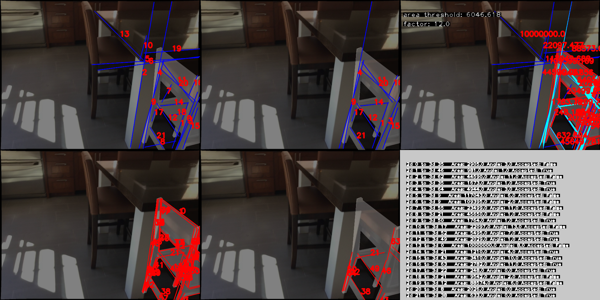

In [65]:
# ipyplot.plot_images([outputs[0][1][0],outputs[1][1][0]], max_images=20, img_width=600)
ipyplot.plot_images([output[2][0] for output in outputs], max_images=20, img_width=600)

In [ ]:
# all_2d_to_all_3d = outputs[0][1]["all_factors_T_2d_3d_selected_T"]


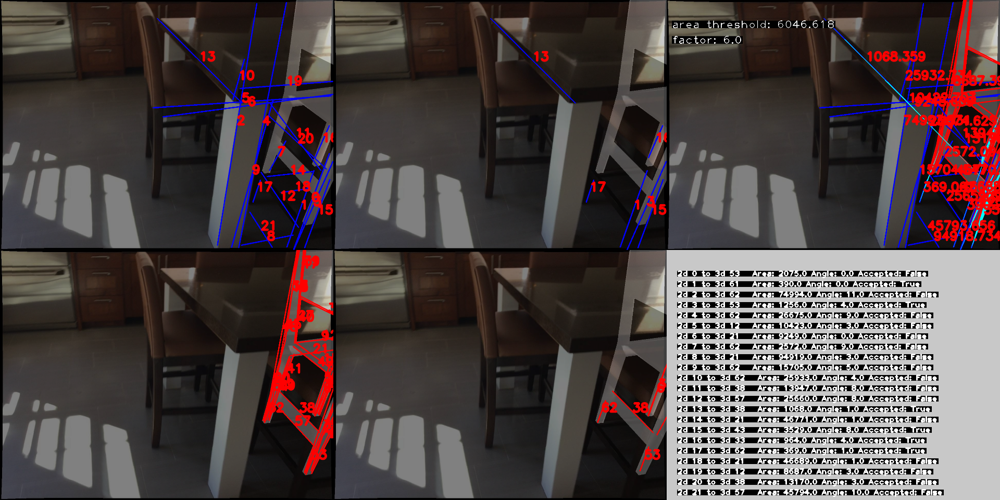
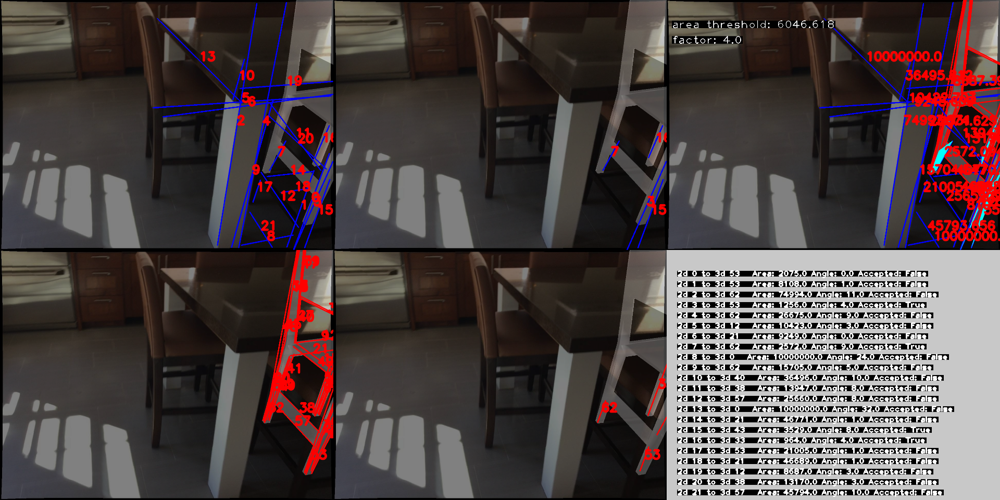


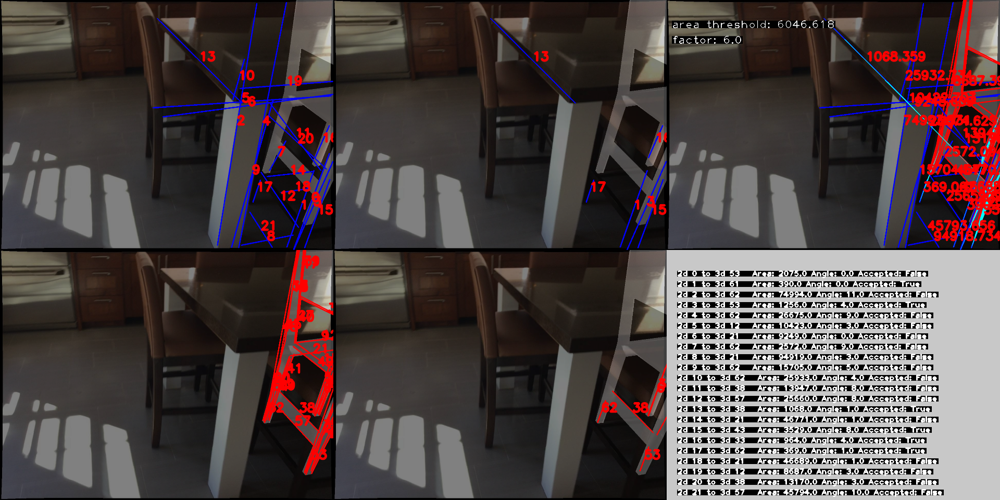
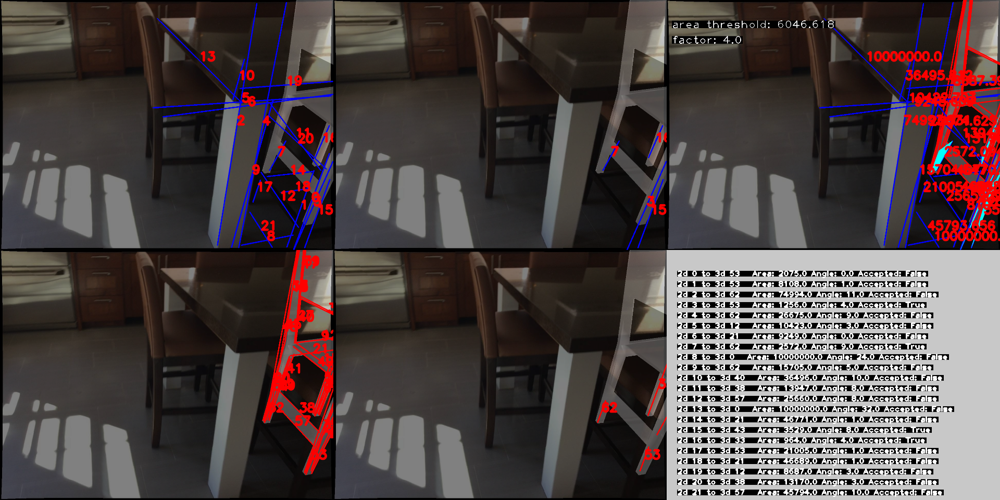

In [66]:
# CLOSEST TO GT TS
ipyplot.plot_images([output[2][1] for output in outputs], max_images=20, img_width=1000)

In [67]:
area_accepted_gt = outputs[0][1]['all_accepted_T_2d_closest_gt']
all_factors_T_2d_closest_gt = outputs[0][1]['all_factors_T_2d_closest_gt']

def get_threshold_for_max_area(area_accepted_gt,all_factors_T_2d_closest_gt,w=1296):
    max_area = np.max(all_factors_T_2d_closest_gt[area_accepted_gt])
    return max_area ** 0.5 / w

threshold = get_threshold_for_max_area(area_accepted_gt,all_factors_T_2d_closest_gt)
print(threshold)

0.045836069266660416


In [68]:
# for BBOX
for i in range(len(configs)):
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    Ts = np.array(factor_output["T"])
    if i == 0:
        factor = np.array(factor_output["box_iou"])
    if i == 1:
        factor = np.array(factor_output["area_accepted_all_Ts"])
    create_k3d_plot(Ts,factor,np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),highlight='max',relative_highlight_size=1)
    # print(factor)


KeyError: 'box_iou'

In [69]:
for i in range(len(configs)):
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    # have zeros if not 
    Ts = np.array(factor_output["T"])
    area_accpeted_all_Ts = np.array(factor_output["area_accepted_all_Ts"])
    # print(Ts)
    create_k3d_plot(Ts,area_accpeted_all_Ts,np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),highlight='min',relative_highlight_size=1)
    print(factor_output["area_accepted_all_Ts"])

/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

[87434.75 87434.75 87434.75 ... 87434.75 87434.75 87434.75]


Output()

[81595.44 81595.44 81595.44 ... 81595.44 81595.44 81595.44]


In [71]:
# in image x point left, y points up and z points into image
for i in range(len(configs)):
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    Ts = np.array(factor_output["T"])
    factors = np.array(factor_output["n_accepted_all_Ts"])
    create_k3d_plot(np.array(Ts),np.array(factors),np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),relative_highlight_size=1.)

/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

Output()

In [ ]:
for i in range(len(configs)):
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    Ts = np.array(factor_output["T"])
    factors = np.array(factor_output["n_accepted_all_Ts"])

    mask_factors = np.array(factors) > 11.5
    factors = 1- mask_factors * 1
    create_k3d_plot(np.array(Ts),np.array(factors),np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),relative_highlight_size=1)


Output()

In [ ]:
all_2d_to_all_3d = outputs[0][1]["all_factors_T_2d_3d_selected_T"]
print(all_2d_to_all_3d.shape)

(31, 65)
